In [140]:
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
df = pd.read_csv("BTC.csv", index_col=0, parse_dates=True)
df.head()

,open,high,low,close,volume
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533


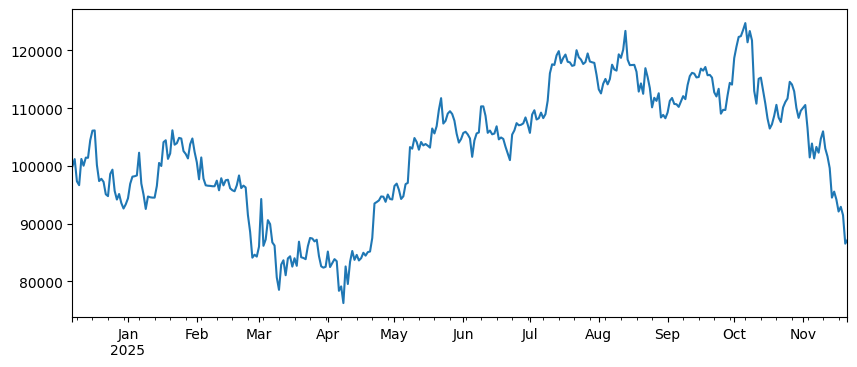

In [142]:
fig, ax = plt.subplots(figsize=(10, 4))
df["close"].plot(ax=ax)
plt.show()

#### Creating the strategy

In [143]:
def compute_support_resistance(df, window=20, shift_levels=1):
    df = df.copy()
    #Rolling low and high of closing prices
    df["support"] = df["close"].rolling(window=window, min_periods=1).min()
    df["resistance"]= df["close"].rolling(window=window, min_periods=1).max()

    #Shift levels forward to avaoid using future information

    df["support"] = df["support"].shift(shift_levels)
    df["resistance"] = df["resistance"].shift(shift_levels)
    return df

df = compute_support_resistance(df)

In [144]:
df

,open,high,low,close,volume,support,resistance
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99
...,...,...,...,...,...,...,...
2025-11-17,94182.03,95950.00,91158.35,92100.60,13319.956338,94183.97,112906.75
2025-11-18,92100.60,93775.00,89183.48,92914.46,16182.467229,92100.60,110536.01
2025-11-19,92914.45,92948.00,88483.12,91461.60,15642.233203,92100.60,110536.01
2025-11-20,91465.04,93080.91,85980.70,86536.88,18857.801349,91461.60,110536.01


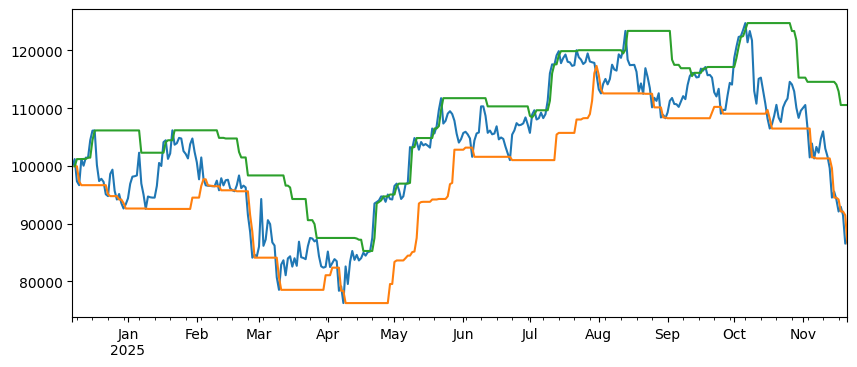

In [145]:
fig, ax = plt.subplots(figsize=(10, 4))
df["close"].plot(ax=ax)
df["support"].plot(ax=ax)
df["resistance"].plot(ax=ax)
plt.show()

##### Generating Entry Signal (Fakeout Entry)

In [146]:
def generate_entry_signal(df):
    """
    Create raw entry signal:
    We only mark the moment price touches or goes below support.
    ML will later decide whether it's a good long entry.
    """
    df = df.copy()
    
    # event: price touches or goes <= support
    df['entry_raw'] = (df['close'] <= df['support']) & df['support'].notna()

    return df


In [147]:
df = generate_entry_signal(df)
df.head()

,open,high,low,close,volume,support,resistance,entry_raw
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN,False
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32,False
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99,True
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99,True
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99,False


##### Generating Exit Signal

In [148]:
def generate_exit_signal(df):
    """ 
    Create exit signal.
    Exit when close touches or exceeds rolling resistance.
    """
    df = df.copy()
    df["exit_raw"] = (df["close"] >= df["resistance"]) & df["resistance"].notna()
    return df

In [149]:
df = generate_exit_signal(df)
df.head()

,open,high,low,close,volume,support,resistance,entry_raw,exit_raw
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN,False,False
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32,False,True
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99,True,False
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99,True,False
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99,False,True


##### Build Positions (State machine Logic)

    - We create a position column
    - Position = 1 -> we are in a long trade
    - Position = 0 -> we are flat(waiting for next entry)

The Logic - 

- If we are flat and entry_raw == True -> Enter long
- If we are in a long and exit_raw == True -> Exit
- If we are in a long and SL hits, -> Exit
- While in a trade, ingore all new entry_raw signals

This ensures -

- No double entries
- No rebuying inside an open Trade
- Clear start and end of every trade
- Takes real stop loss into account

In [150]:
def build_position(
        df, sl_buffer =0.01,
        entry_col="entry_raw",
        exit_col="exit_raw"
):
    """ 
    Build position column using:
    - Entry signal
    - Exit signal(resistance)
    - Support-break stop-loss (parameterized by sl_buffer)

    sl_buffer = stop-loss distance below support (fraction)
        e.g., 0.01 -> 1% below support
    """
    df = df.copy()

    #Define stop-loss condition

    df["stop_loss_raw"] = df["close"] < (df["support"] * (1-sl_buffer))

    #Initialize
    pos = 0
    positions = []

    for i in range(len(df)):
        entry_signal = df[entry_col].iloc[i]
        exit_signal = df[exit_col].iloc[i]
        stop_signal = df["stop_loss_raw"].iloc[i]

        if pos == 0:
            # This means flat -> can enter only on entry signal
            if entry_signal:
                pos = 1
        else:
            # If already in a long position -> eixt on resistance OR stop-loss
            if exit_signal or stop_signal:
                pos =0 
        positions.append(pos)
    
    df["position"] = positions

    return df

In [151]:
df = build_position(df)
df.head()

,open,high,low,close,volume,support,resistance,entry_raw,exit_raw,stop_loss_raw,position
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN,False,False,False,0
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32,False,True,False,0
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99,True,False,True,1
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99,True,False,False,1
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99,False,True,False,0


##### Compute Strategy returns

In [152]:
def compute_strategy_returns(df, starting_capital=100000):
    """ 
    Extremely simple loop-based PnL calculation.
    - No slippage
    - No fees
    - Uses recoreded "position" (0 or 1)
    - Updates equity step by step
    """

    df = df.copy()
    equity = starting_capital
    equity_list = [equity]

    in_trade = False
    entry_price = None

    # Loop through the dataframe row by row

    for i in range(1, len(df)):
        pos_prev = df["position"].iloc[i-1]
        pos_now = df["position"].iloc[i]
        price_now = df["close"].iloc[i]

        # Detect entry
        if pos_prev == 0 and pos_now ==1:
            entry_price = price_now
        
        # Detect exit

        if pos_prev == 1 and pos_now == 0:
            exit_price = price_now
            ret = (exit_price - entry_price)/ entry_price
            equity = equity * (1+ret)
            in_trade = False
            entry_price = None
        
        #equity stays the same until the trade closes
        equity_list.append(equity)
    
    df["equity"] = equity_list
    df["cumulative_return"] = (df["equity"]/starting_capital) - 1
    return df



In [153]:
df= compute_strategy_returns(df)
df

,open,high,low,close,volume,support,resistance,entry_raw,exit_raw,stop_loss_raw,position,equity,cumulative_return
2024-12-07,99885.37,100583.27,99012.73,99929.32,4774.350878,NaN,NaN,False,False,False,0,100000.000000,0.000000
2024-12-08,99919.20,101435.05,98729.66,101174.99,4230.352252,99929.32,99929.32,False,True,False,0,100000.000000,0.000000
2024-12-09,101175.00,101290.73,94220.80,97324.81,20103.050735,99929.32,101174.99,True,False,True,1,100000.000000,0.000000
2024-12-10,97330.66,98338.17,94273.38,96660.76,20620.538775,97324.81,101174.99,True,False,False,1,100000.000000,0.000000
2024-12-11,96660.75,101984.98,95722.79,101202.11,21190.237533,96660.76,101174.99,False,True,False,0,103983.876259,0.039839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-17,94182.03,95950.00,91158.35,92100.60,13319.956338,94183.97,112906.75,True,False,True,0,116693.565058,0.166936
2025-11-18,92100.60,93775.00,89183.48,92914.46,16182.467229,92100.60,110536.01,False,False,False,0,116693.565058,0.166936
2025-11-19,92914.45,92948.00,88483.12,91461.60,15642.233203,92100.60,110536.01,True,False,False,1,116693.565058,0.166936
2025-11-20,91465.04,93080.91,85980.70,86536.88,18857.801349,91461.60,110536.01,True,False,True,0,110410.238135,0.104102


In [154]:
def plot_equity_vs_price(df):
    fig,ax = plt.subplots(figsize=(12,6))

    plt.plot(df.index, df["close"])
    plt.title("Closing Price")
    plt.ylabel("Price")

    #PLot the returns curve

    plt.plot(df.index, df["equity"])
    plt.title("Closing Price")
    plt.ylabel("Price")


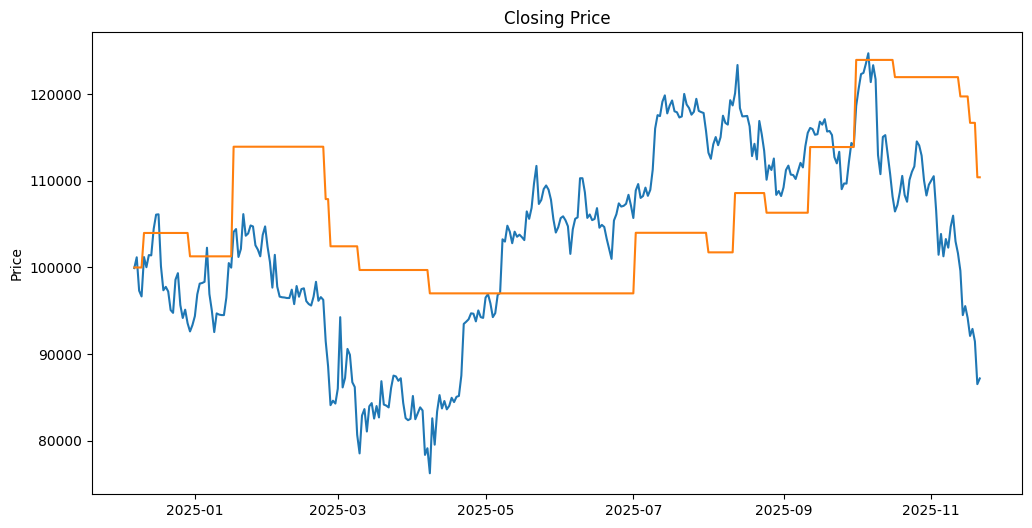

In [155]:
plot_equity_vs_price(df)